In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

np.set_printoptions(suppress=True)
np.set_printoptions(precision=2) #设精度为3
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [2]:
data = np.loadtxt("./data/data2.csv", delimiter=",", skiprows=1)
# print(data[0:10,0])
# print(data[0:10,1])

1.0621092063234407


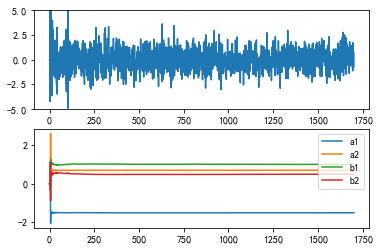

In [5]:
# RGLS
# 参数初始化
na = 2
nb = 2
nc = 2
nMax = max(na, nb, nc)
L = 1700 # 数据长度
a = 100

# 序列初始化
e1 = np.zeros(L + nMax) # 误差 数 残差
h = np.zeros((L + nMax, na + nb, 1))
hf = np.zeros((L + nMax, na + nb, 1)) # 滤波数据向量
he = np.zeros((L + nMax, nc, 1)) # 噪声数据向量
Theta = np.zeros((L + nMax, na + nb, 1))   # [a1,a2,b1,b2].T
P = np.array([a**2 * np.eye((na + nb))] * (L + nMax))
K = np.zeros((L + nMax, na + nb, 1)) # 算法增益
Inn = np.zeros(L + nMax) # 数 新息
s = np.zeros(L + nMax) # 数

Thetae = np.zeros((L + nMax, nc, 1))   # 噪声估计向量
Pe = np.array([a**2 * np.eye((nc))] * (L + nMax))
Ke = np.zeros((L + nMax, nc, 1)) # 噪声算法增益
Inne = np.zeros(L + nMax) # 数 噪声新息
se = np.zeros(L + nMax) # 数
# 损失函数
J = np.zeros(L + nMax) # 数
Je = np.zeros(L + nMax) # 数

u = data[:, 0]
z = data[:, 1]
uf = np.zeros(len(u))
zf = np.zeros(len(z))
v1 = np.zeros(L + nMax)
z_pre = np.ones((len(z), 1))
k = 0
for k in range(nMax, L + nMax):
    zf[k] = z[k]
    uf[k] = u[k]
    for i in range(nc): 
        zf[k] += Thetae[k-1][i] * z[k-i-1]
        uf[k] += Thetae[k-1][i] * u[k-i-1]
    for i in range(na):
        hf[k][i] = -1 * zf[k - i - 1]
        h[k][i] = -1 * z[k - i - 1]
    for j in range(nb):
        hf[k][na + j] = uf[k - j - 1]
        h[k][na + j] = u[k - j - 1]
    for i in range(nc):    
        he[k][i] = -1 * e1[k - i - 1]
        
    s[k] = hf[k].T @ P[k - 1] @ hf[k] + 1.0
    Inn[k] = zf[k] - hf[k].T @ Theta[k - 1]
    K[k] = P[k - 1] @ hf[k] / s[k]
    P[k] = P[k - 1] - K[k] @ K[k].T * s[k]
    Theta[k] = Theta[k - 1] + K[k] * Inn[k]
    
    se[k] = he[k].T @ Pe[k-1] @ he[k] + 1.0
    e1[k] = z[k] - h[k].T @ Theta[k]
    Inne[k] = e1[k] - he[k].T @ Thetae[k-1]
    Ke[k] = Pe[k-1] @ he[k] / se[k]
    Pe[k] = Pe[k-1] - Ke[k] @ Ke[k].T * se[k]
    Thetae[k] = Thetae[k-1] + Ke[k] * Inne[k]
    v1[k] = e1[k] - he[k].T @ Thetae[k]
    
    J[k] = J[k-1] + Inn[k]**2 / s[k]
    Je[k] = Je[k-1] + Inne[k]**2 / se[k]
    if k >= nMax:
        z_pre[k] = h[k].T @ Theta[k] + e1[k]
        
ax3 = plt.subplot(2,1,1)
ax3.plot(range(len(Inn)), Inn)
plt.ylim([-5, 5])  # y轴边界
ax4 = plt.subplot(2,1,2)
ax4.plot(range(L + nMax),Theta[:,0],
        range(L + nMax),Theta[:,1],
        range(L + nMax),Theta[:,2],
        range(L + nMax),Theta[:,3],)
ax4.legend(["a1", "a2", "b1", "b2"])
print(np.sqrt(J[L + nMax - 1]/L))

In [6]:
Theta[k]

array([[-1.5],
       [ 0.7],
       [ 1. ],
       [ 0.5]])

In [7]:
Thetae[k]

array([[0.94],
       [0.42]])

In [ ]:
# ============================残差白噪声检验============================================

[-0.13  0.    0.02  0.15  0.    0.04 -0.03  0.   -0.    0.03 -0.01  0.
  0.04 -0.02  0.03 -0.01  0.01  0.05  0.    0.    0.03  0.01  0.04  0.02
  0.01  0.02 -0.02  0.07 -0.   -0.  ]
100.06472189259786 ? 42.78084504248447


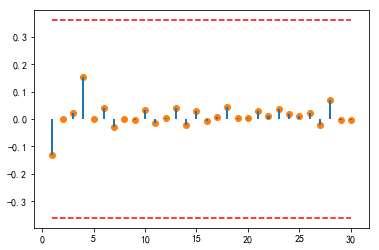

In [8]:
err = v1
# 残差白噪声检验
# 
Re_0 = 0.0
for i in range(2*nMax+1, L + nMax+1):
    Re_0 += err[i-1]**2 / (L - nMax)
    
Lr = 30
lou_e = np.zeros(Lr)
for r in range(1, Lr+1):
    for k in range(2*nMax+1, L + nMax -r+1):
        lou_e[r-1] = lou_e[r-1] + err[k-1] * err[k-1 + r]/(L - nMax -r)
    lou_e[r-1] = lou_e[r-1]/Re_0

print(lou_e)
plt.bar(range(1, Lr+1), height=lou_e, width=0.2, align='center',)
plt.scatter(range(1, Lr+1), lou_e, )
plot_scale = 1.0
plt.plot([1,Lr], [1.98*plot_scale/np.sqrt(Lr), 1.98*plot_scale/np.sqrt(Lr)], 'r--')
plt.plot([1,Lr], [-1.98*plot_scale/np.sqrt(Lr), -1.98*plot_scale/np.sqrt(Lr)], 'r--')

# 计算残差估计值相关系数平方和
lou_e_2 = 0
for r in range(Lr):
    lou_e_2 += lou_e[r]**2
lou_e_2 = (L - nMax)*lou_e_2
lou_e_2_threshold = Lr + 1.65*np.sqrt(2*Lr)
print(lou_e_2, "?",lou_e_2_threshold)